In [87]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt
from Lambda_feature import *
import math
from sklearn.neighbors import KDTree
from scipy.spatial import distance_matrix
from DTM_filtrations import *

def perturb(X):
    mean = np.array([0,0])
    cov = np.eye(2)*0.015
    ptb = np.random.multivariate_normal(mean, cov, X.shape[0])
    return X+ptb

def add_uni_noise(X,N):
    xy_min = [np.min(X[:,0]),np.min(X[:,1])]
    xy_max = [np.max(X[:,0]),np.max(X[:,1])]
    noise = np.random.uniform(low=xy_min, high=xy_max, size=(N,2))
    return np.r_[X,noise]

def generate_data():
    N = 200
    angles = np.linspace(0,2*np.pi,num=N)
    r1,r2 = 10,2
    c1 = np.array([[r1*np.cos(x),r1*np.sin(x)] for x in angles])
    c2 = np.array([[r2*np.cos(x),r2*np.sin(x)] for x in angles])+np.array([20,0])
    c1,c2 = add_uni_noise(perturb(c1),20),add_uni_noise(perturb(c2),20)
    return np.r_[c1,c2]

def LK_app(dm1,dm2):
    neigh = NearestNeighbors(n_neighbors=1,metric='precomputed')
    neigh.fit(dm1)
    NN_dist,NN = neigh.kneighbors(dm2,return_distance=True)
    return NN_dist*4

def CKNN_app(X,query_pts,m,dm=None):
    N_tot = X.shape[0]     
    k = math.floor(m*N_tot)+1   # number of neighbors
    kdt = KDTree(X, leaf_size=30, metric='euclidean')
    NN_Dist, NN = kdt.query(X, k, return_distance=True)  
    NN_Dist = NN_Dist.reshape((N_tot,k))
    knn_dist = NN_Dist[:,-1]
    knn_dist = knn_dist.reshape((N_tot,1))
    dm = distance_matrix(X,query_pts,p=2)
    dm_cknn = dm/knn_dist
    cknn_fv = np.min(dm_cknn,axis=0)
    return cknn_fv*2

def draw_sublevel(data,thres,value,qps):
    idx = np.where(value<thres)[0]
    qps = qps[idx,:]
    plt.figure()
    plt.scatter(qps[:,0],qps[:,1],c='#90EE90',s=10)
    plt.scatter(data[:,0],data[:,1],s=2,c='black')
    plt.xticks([]),plt.yticks([])
    plt.axis('equal')
    plt.title('Sublevel Set under '+str(thres))

Text(0.5, 1.0, 'Original Point Cloud')

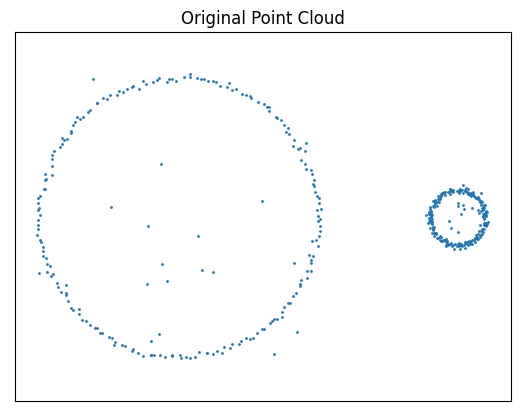

In [88]:
# Genarate Data
X = generate_data()
plt.scatter(X[:,0],X[:,1],s=1)
plt.axis('equal')
plt.xticks([]),plt.yticks([])
plt.title('Original Point Cloud')

In [89]:
# Generate query points
min_0,max_0 = np.min(X[:,0]),np.max(X[:,0])
min_1,max_1 = np.min(X[:,1]),np.max(X[:,1])
num = 500
x = np.linspace(min_0,max_0,num)
y = np.linspace(min_1,max_1,num)
a,b = np.meshgrid(x,y)
a = a.reshape((int(a.size),1))
b = b.reshape((int(b.size),1))
query_points = np.concatenate((a,b),axis=1)

In [90]:
# Choose Your Filter Here 
choice_  = 'lambda' 

In [91]:
choice_list = ['rips','cknn','dtm','lambda']
assert choice_ in choice_list, 'Invalid Filter'

In [92]:
# Compute Filter Value of Query Points

if choice_ == 'lambda':
    psi = 16
    _,_,dm,dm2 = lambda_feature_infty(X,query_points,psi=psi,t=100) #eta = ∞
    filter_value = LK_app(dm,dm2)

elif choice_ == 'cknn':
    m = 0.1
    filter_value  = CKNN_app(X,query_points,m)

elif choice_ == 'rips':
    filter_value  = DTM(X,query_points,0)*2

elif choice_ == 'dtm':
    m = 0.1
    filter_value = DTM(X,query_points,m)
    


(([], []), ([], []))

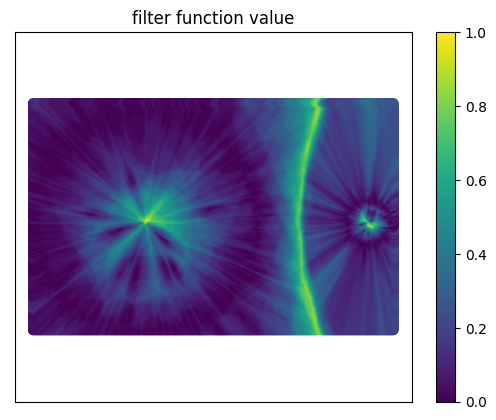

In [93]:
# Plot filter function value
values_ori = np.copy(filter_value) # normalization 
values_scale = values_ori/np.max(values_ori)
plot=plt.scatter(query_points[:,0], query_points[:,1], c=values_scale)
plt.colorbar(plot)
plt.title('filter function value')
plt.axis('equal')
plt.xticks([]),plt.yticks([])

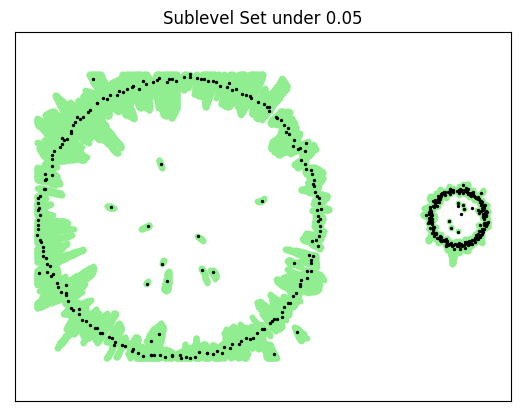

In [94]:
# plot sublevel set

demo_thres_dict = {'cknn':0.5,'lambda':0.05,'rips':2,'dtm':5}
threshold = demo_thres_dict[choice_]
draw_sublevel(X,threshold,filter_value,query_points)
